# ClimaCell New Technologies Homework

***
# Table of Contents

1. [Goals](./climacell_new_technologies_homework.ipynb#goals)
2. [Summary](./climacell_new_technologies_homework.ipynb#summary)
3. [Import Packages](./climacell_new_technologies_homework.ipynb#import)
4. [Load Data](./climacell_new_technologies_homework.ipynb#load)
   1. [Load ASOS CID data](./climacell_new_technologies_homework.ipynb#CID)
   2. [Set correct data types](./climacell_new_technologies_homework.ipynb#types)
   3. [Handle duplicate and missing data](./climacell_new_technologies_homework.ipynb#missing)
5. [Exploratory Data Analysis](./climacell_new_technologies_homework.ipynb#eda)
   1. [Plot data](./climacell_new_technologies_homework.ipynb#plot)
   2. [Autocorrelation](./climacell_new_technologies_homework.ipynb#autocorr)
6. [Model Building](./climacell_new_technologies_homework.ipynb#model)
   1. [ARMA Model](./climacell_new_technologies_homework.ipynb#arma)
7. [Results](./climacell_new_technologies_homework.ipynb#results)
   1. [Forecast](./climacell_new_technologies_homework.ipynb#forecast)
   2. [Error estimation](./climacell_new_technologies_homework.ipynb#error)

***
# Goals <a name="goals"></a>

1. Design  a simple machine learning/statistics-based forecasting model using this data. (No
physical/meteorological modeling.) The goal is to predict the temperature every hour for the day of 2018-06-01 (i.e. midnight to midnight in local time), trained only on data prior to that day.
2. Are there large data gaps? How big? How are you handling this?
3. Is the data on a regular time grid? If not, how are you handling this?
4. Make a plot showing the results of your model, compared to the true temperature data for 2018-06-01.
5. Produce an aggregate error metric to assess your model's performance -- how's it do?
6. Please write a short blurb explaining your methodology/assumptions/etc. Also please discuss other
methodologies that could be investigated, and how they might improve upon your results.

***
# Summary <a name="summary"></a>

I first downloaded air temperature (in Fahrenheit) data from [https://mesonet.agron.iastate.edu/request/download.phtml](https://mesonet.agron.iastate.edu/request/download.phtml) for the \[CID\] Cedar Rapids ASOS station between June 1, 2008 and June 2, 2018 (10 years). After loading the data, I found that there were over 200,000 missing data points, and I dropped these. In addition, the data was collected at uneven intervals: some observations were taken at the same time, and others were taken between 1 minute and 1.5 days apart. To simultaneously smooth over some of the uneven sampling and create a regular hourly time grid, I resampled the data by averaging over 1 hour periods. Then, I addressed the missing values by iteratively filling them in with values from the previous day until they were all filled. At this point, I had a complete data set.

To begin my analysis, I simply plotted the time series, along with a monthy and yearly rolling average. The monthly averages showed a clear seasonality, while the yearly averages showed a stationary overall trend. I also plotted centered temperatures for the average month, reinforcing the seasonality from earlier, and the centered temperatures for the average day, which showed a new daily seasonality. Because this is a univariate time series, I then inspected its autocorrelation (ACF) and partial autocorrelation (PACF) functions at different lag times. I found that much of the autocorrelation was explained by a seasonality of 1 year, as predicted earlier. Differencing by 1 year, and inspecting the new ACF and PACF, I found that just about all of the remaining autocorrelation was explained by a lag of 1 hour. Differencing again by 1 hour, very little autocorrelation remained except at the 2 hour and 1 day lags, but not enough to require another full differencing. Incorporating the 1 day lag into an autoregressive (AR) or moving averages (MA) model would be too memory-intensive, so I looked only at the 2 hour lag. Because both the PACF and ACF plots had a small peak at the 2 hour lag, this suggested an ARMA(2,2) model.

As proof of concept, I fit an ARMA(2,2) model to a training set with a random cutoff date, and used it to forecast the temperatures for the next day. I also used the model to predict its training data. Comparing these to the actual temperature values, I computed the root mean squared error (RMSE) metric for both training and test data and found both to be less than 3$^{\circ}$F. In addition, the actual temperatures fell well within the confidence interval of the forecast values.

To show that ARMA(2,2) is a good model to make this forecast, I trained the model with all combinations of p autoregressive (AR) terms and q moving-average (MA) terms with $0 \leq p, q \leq 2$, and computed both the Akaike information criterion (AIC) and Bayesian information criterion (BIC) for each to minimize the relative information lost by each model, while penalizing a higher number of model parameters. For both metrics, the model with the least information lost is ARMA(2,2), and so I am confident that this model is a good estimate. Then, in order to get a better idea of my model accuracy, I plotted the RMSE for both training and test data as I varied the training set cutoff date. I found that the training RMSE stayed constant at ~2.5$^{\circ}$F, while the test RMSE fluctuated, but stayed under 6$^{\circ}$F.

Finally, I forecast the temperature at the Cedar Rapids, Iowa (CID) ASOS weather station for 2018-06-01. I found that both the training and test RMSE were ~2.5$^{\circ}$F, and that the actual values stayed well within the confidence interval of the forecast.

One way to achieve better performance would be to increase the complexity of the model (i.e. more AR and MA terms). In particular, I think that if it were computationally reasonable to implement an ARMA(24,24), using the ACF and PACF peaks around lag 24, I might have been able to achieve even better results. Also, if there were more sources of data available, such as nearby weather stations, CO$_{2}$ levels, etc. I could implement a multivariate model that might improve performance.

***
# Import Packages <a name="import"></a>

In [1]:
# General packages
from itertools import product
import warnings
warnings.filterwarnings('ignore')

# Data packages
import numpy as np
import pandas as pd

# Visualization packages
import matplotlib.pyplot as plt

# Helper functions
from helper_funcs import *

***
# Load Data <a name="load"></a>

## Load ASOS CID data <a name="CID"></a>

Air temperature (in Fahrenheit) data was downloaded from [https://mesonet.agron.iastate.edu/request/download.phtml](https://mesonet.agron.iastate.edu/request/download.phtml) for the \[CID\] Cedar Rapids ASOS station between June 1, 2008 and June 2, 2018 (10 years). The features given are:

1. valid: The timestamp of the observation in local time (CST)
2. station: Three or four character site identifier
3. lon: Longitude of site
4. lat: Lattitude of site
5. tmpf: Air temperature in Fahrenheit

The 'valid' feature must be parsed as a datetime type, and set as the index in ascending order.

In [2]:
temp_df = pd.read_csv("CID.txt", parse_dates = ['valid']).set_index('valid').sort_index()

The 'station', 'lon', and 'lat' features are constant and can be removed from our dataframe. We are left with the series tmpf.

In [3]:
temp_df.station.nunique(), temp_df.lon.nunique(), temp_df.lat.nunique()

(1, 1, 1)

In [4]:
tmpf = temp_df.tmpf

## Set correct data types <a name="types"></a>

We see that the 'tmpf' feature is given as an object, so we identify all the non-numeric elements. It appears that the character 'M' is a placeholder for missing values, and there are no other non-numeric elements. We then force-convert these to floats.

In [5]:
tmpf.dtype.type

numpy.object_

In [6]:
non_numerical_values = tmpf[~tmpf.str.match('[0-9\-\.]+')]
non_numerical_values.unique(), non_numerical_values.size

(array(['M'], dtype=object), 215094)

In [7]:
tmpf = pd.to_numeric(tmpf, errors = 'coerce')

## Handle duplicate and missing data <a name="missing"></a>

Drop all observations with missing values.

In [8]:
tmpf = tmpf.dropna()

We find that minimum observation resolution is down to the minute. Taking time differences between consecutive observations, we see that there are some observations taken at the same time, and some gaps in the data ranging from 1 minute to 1.5 days.

In [9]:
np.diff(tmpf.index.unique()).min().astype('timedelta64[s]')

numpy.timedelta64(60,'s')

In [10]:
np.unique(np.diff(tmpf.index.values).astype('timedelta64[m]'))

array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
         11,   12,   13,   14,   15,   16,   17,   18,   19,   20,   21,
         22,   23,   24,   25,   26,   27,   28,   29,   30,   31,   32,
         33,   34,   35,   36,   37,   38,   39,   40,   41,   42,   43,
         44,   45,   46,   47,   48,   49,   50,   51,   52,   53,   54,
         55,   56,   57,   58,   59,   60,   61,   62,   63,   64,   65,
         67,   68,   70,   71,   72,   73,   74,   79,   80,   85,   86,
         87,   92,   94,   95,   97,  104,  105,  106,  107,  108,  109,
        112,  113,  115,  117,  118,  120,  130,  131,  153,  157,  159,
        180,  237,  240,  243,  247,  291,  300,  320,  350,  353,  357,
        360,  364,  365,  420,  480,  540,  657,  660,  780, 1740, 2100],
      dtype='timedelta64[m]')

Create regular hourly time grid and smooth over duplicate observations by resampling data averaged over 1 hour periods.

In [11]:
tmpf = tmpf.resample('H').mean()

Fill in missing values using values at the same time on the previous day. Iterate this step until all missing values are filled in.

In [12]:
while tmpf.isnull().sum() > 0:
    tmpf = tmpf.fillna(tmpf.shift(24))

***
# Exploratory Data Analysis <a name="eda"></a>

## Plot data <a name="plot"></a>

We plot the hourly temperature data, along with rolling monthly and yearly means for the full 10 year period. There is a clear yearly seasonality, but after averaging over full years the time series appears to be stationary around a mean of ~50$^{\circ}$F.

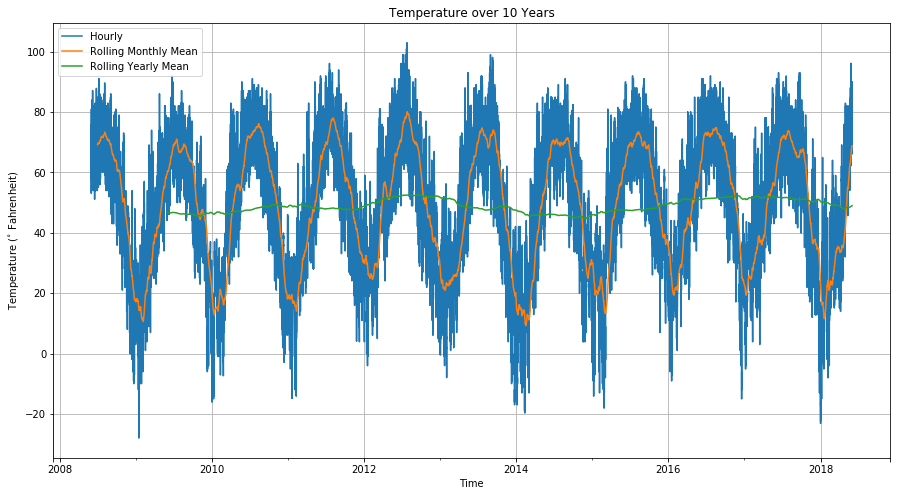

In [13]:
monthly_means = tmpf.rolling(24 * 30).mean()
yearly_means = tmpf.rolling(24 * 365).mean()

fig, ax = plt.subplots(figsize = (15, 8))
tmpf.plot(ax = ax, grid = True, label = 'Hourly')
monthly_means.plot(ax = ax, grid = True, label = 'Rolling Monthly Mean')
yearly_means.plot(ax = ax, grid = True, label = 'Rolling Yearly Mean')
ax.legend()
ax.set_title('Temperature over 10 Years')
ax.set_xlabel('Time');
ax.set_ylabel('Temperature ($^{\circ}$ Fahrenheit)');

We plot the average yearly seasonality (centered around the mean) and find an average temperature fluctuation ~55$^{\circ}$F $\pm$ 10$^{\circ}$F. If we zoom in further and plot the average daily seasonality (centered around a given month's mean), we also notice an average temperature fluctuation of ~20$^{\circ}$F $\pm$ 10$^{\circ}$F.

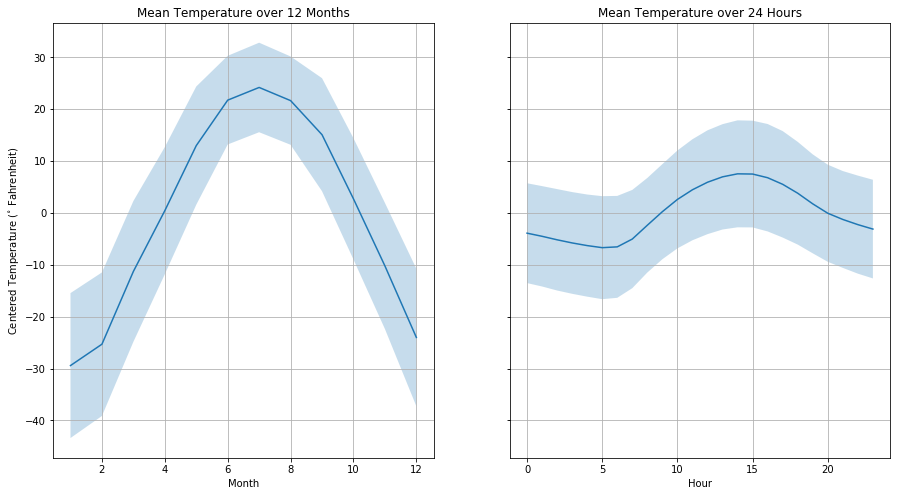

In [14]:
fig, ax = plt.subplots(figsize = (15, 8), ncols = 2, sharey = True)

month_groups = (tmpf - tmpf.mean()).groupby(tmpf.index.month)
monthly_mean, monthly_std = month_groups.mean(), month_groups.std()

monthly_mean.plot(ax = ax[0], grid = True);
plot_ci(monthly_mean.index, monthly_mean, monthly_std, monthly_std, alpha = 0.25, ax = ax[0]);
ax[0].set_title('Mean Temperature over 12 Months')
ax[0].set_xlabel('Month');
ax[0].set_ylabel('Centered Temperature ($^{\circ}$ Fahrenheit)');

hour_groups = (tmpf - tmpf.resample('M').transform('mean')).groupby(tmpf.index.hour)
hourly_mean, hourly_std = hour_groups.mean(), hour_groups.std()

hourly_mean.plot(ax = ax[1], grid = True);
plot_ci(hourly_mean.index, hourly_mean, hourly_std, hourly_std, alpha = 0.25, ax = ax[1]);
ax[1].set_title('Mean Temperature over 24 Hours')
ax[1].set_xlabel('Hour');
ax[1].set_ylabel('Centered Temperature ($^{\circ}$ Fahrenheit)');

## Autocorrelations <a name="autocorr"></a>

We plot the autocorrelation function (ACF) and partial autocorrelation function (PACF) of the time series, resampled as monthly averages. By looking at the ACF, we see that there is a large autocorrelation with a lag of 12 months, and from the PACF it seems that much of the autocorrelation is explained by this 12 month seasonality.

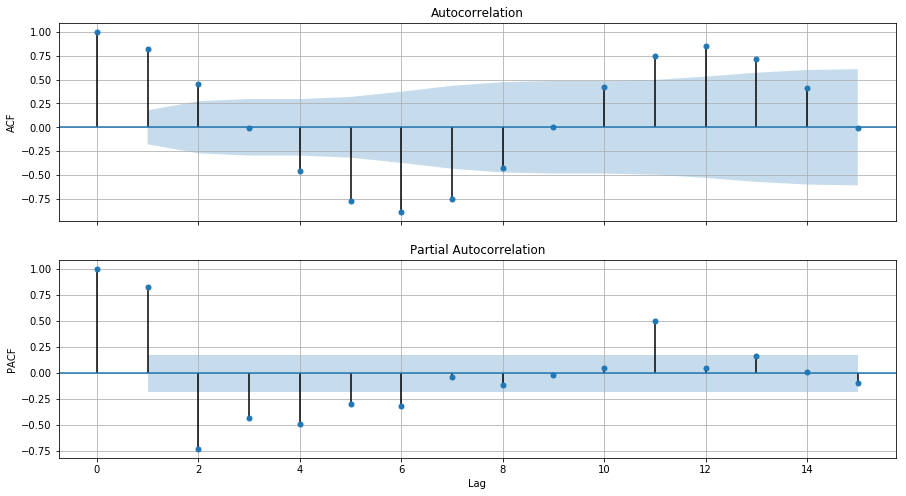

In [15]:
plot_autocorr(tmpf.resample('M').mean(), lags = 15)

To account for the 12 month seasonality, we difference the time series with a lag of 12 months (365 days), and recompute the ACF and PACF of the time series, now resampled as daily averages. Here the PACF shows that a seasonality of 1 day explains most of the remaining autocorrelation.

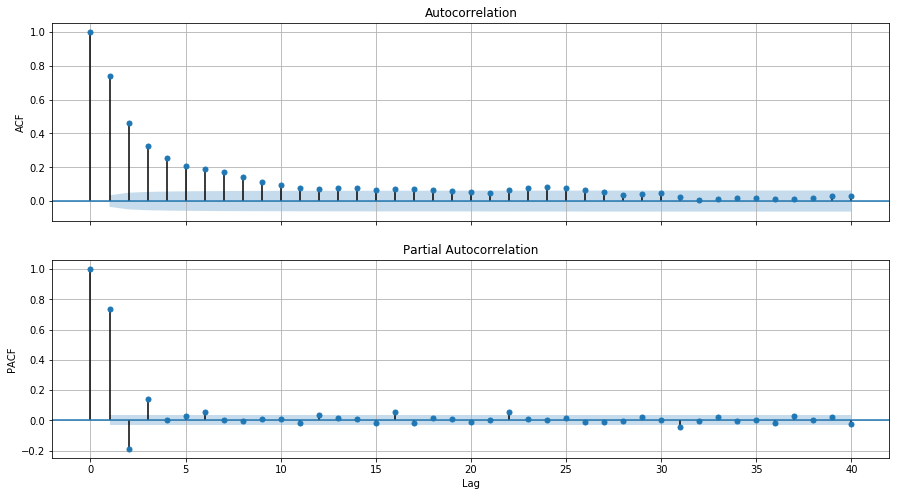

In [16]:
plot_autocorr(tmpf.resample('D').mean().diff(365).dropna(), lags = 40)

However, if we recompute the ACF and PACF of the same time series, but resampled as hourly averages, the PACF shows that a seasonality of 1 hour captures even more of the remaining autocorrelation than the 1 day estimate.

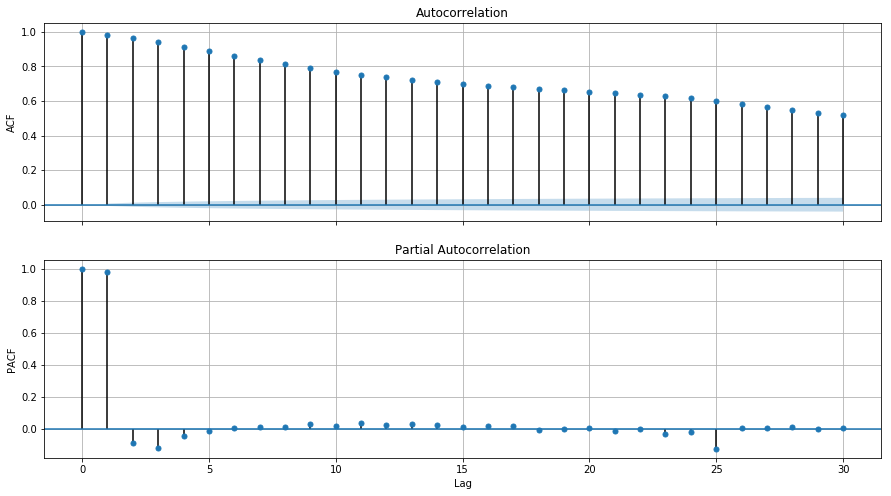

In [17]:
plot_autocorr(tmpf.diff(24 * 365).dropna(), lags = 30)

We account for this 1 hour seasonality by differencing the time series again with a lag of 1 hour. We plot the ACF and PACF, and find that most of the autocorrelation has now been accounted for.

However, there are still small peaks in both plots at a lag of 2 hours and 24 hours. Since the peaks on the PACF plot are $\ll$1, they do not account for seasonality, and we will not take a full difference but rather incorporate them into an autoregressive (AR) model. Also, because we want hourly forecasts and AR(24) is very memory intensive, we will neglect the peak with lag 24 and begin with an AR(2) model.

In addition, the ACF plot also has small peaks at lags of 2 hours and 24 hours. This suggests that we should use a moving averages model (MA) to account for some slight over-differencing. Again, we neglect the peak with lag 24, and add an MA(2) model.

This leaves us with an ARMA(2,2) model on our time series after differencing first by a lag of 1 year and again by a lag of 1 hour.

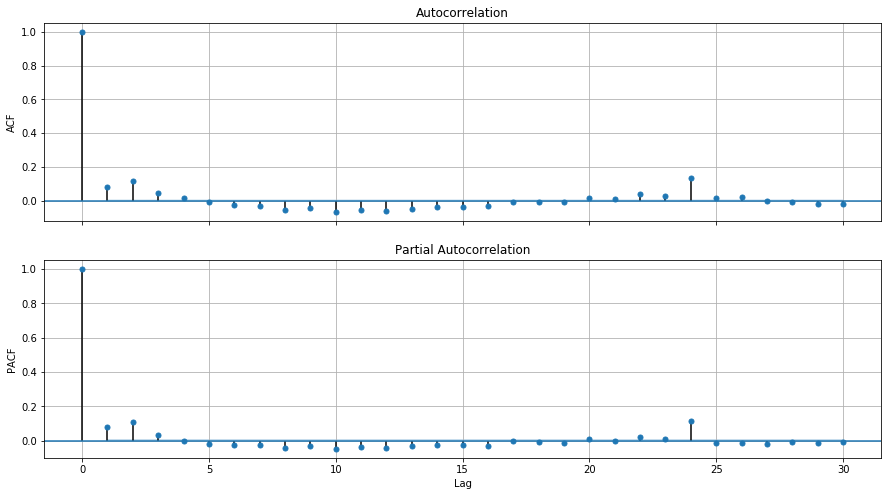

In [18]:
plot_autocorr(tmpf.diff(24 * 365).diff(1).dropna(), lags = 30)

***
# Model Building <a name="model"></a>

## ARMA model <a name="arma"></a>

In the previous section, we deduced that we should use an ARMA(2,2) model on our time series after differencing by 1 year and then 1 hour. Here, we show proof of concept by training the model on all the data up to a random cutoff date, and forecast the temperature for the next 24 hours. We compare this to the actual data for the next 24 hours, and report the root mean squared error (RMSE) metric for both the training and test sets.

RMSE (train): 2.691880072226978
RMSE (test): 1.4639925368625704


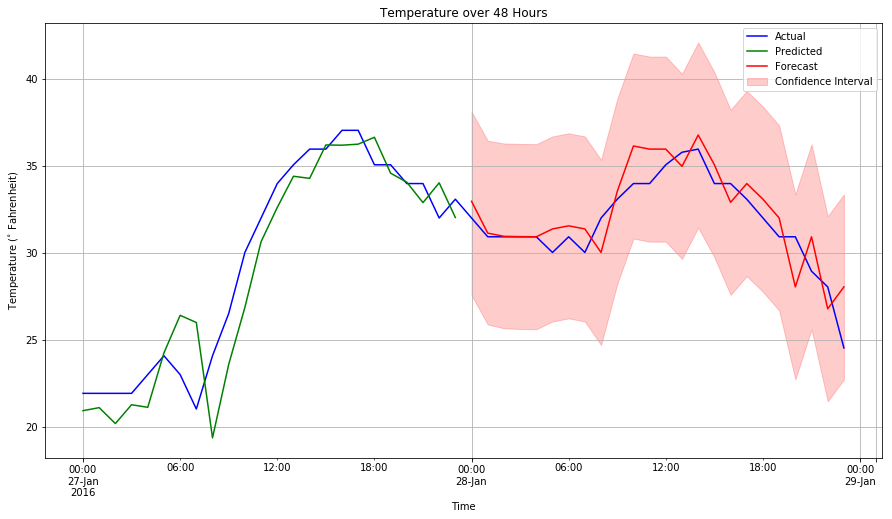

In [19]:
date = np.random.choice(np.unique(tmpf[tmpf.index > tmpf.index.min() + pd.DateOffset(365)].index.date))

model, train, test, predict, forecast_df = ARMA_train_forecast(tmpf, date, diffs = [24 * 365, 1],
                                                                           order = (2, 2),
                                                                           freq = 'H')

plot_ARMA(train, test, predict, forecast_df, plot_hours = 24 * 2, figsize = (15, 8))

***
# Results <a name="results"></a>

## Forecast <a name="forecast"></a>

Finally, we are in a position to forecast the temperature at the Cedar Rapids, Iowa (CID) ASOS weather station for 2018-06-01. We plot the actual temperature over this day and the previous day, the predicted temperature for the previous day, and the forecast temperature for this day along with its confidence interval. We see that the actual temperature falls well within the confidence interval of the forecast. In addition, the RMSE error metric for both the training and test sets are ~2.5$^{\circ}$F, which is fairly low and suggests a good prediction!

RMSE (train): 2.6239058648284725
RMSE (test): 2.4048895968852384


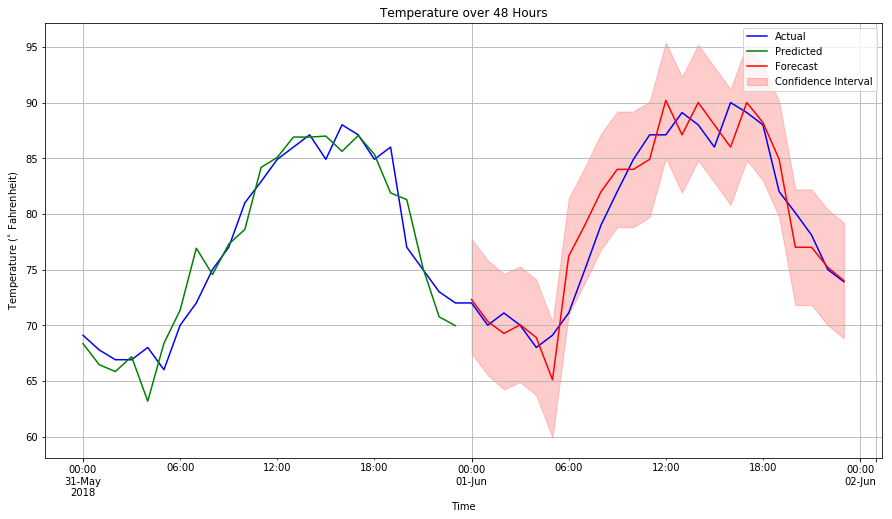

In [20]:
date = pd.to_datetime('6/1/2018').date()

model, train, test, predict, forecast_df = ARMA_train_forecast(tmpf, date, diffs = [24 * 365, 1],
                                                                           order = (2, 2),
                                                                           freq = 'H')

plot_ARMA(train, test, predict, forecast_df, plot_hours = 24 * 2, figsize = (15, 8))

## Error estimation <a name="error"></a>

In order to show that we have chosen the best ARMA model to make this forecast, we train the model with all combinations of p autoregressive (AR) terms and q moving-average (MA) terms with $0 \leq p, q \leq 2$, and compute both the Akaike information criterion (AIC) and Bayesian information criterion (BIC) for each to minimize the relative information lost by each model, while penalizing a higher number of model parameters. For both metrics, the model with the least information lost is ARMA(2,2), and so we are confident that this model is a good estimate.

**(Note: This cell may take a while to run.)**

In [21]:
%%time

date = pd.to_datetime('6/1/2018').date()

orders = list(product(range(3), range(3)))
aics = []
bics = []

for order in orders:
    model, train, test, predict, forecast_df = ARMA_train_forecast(tmpf, date, diffs = [24 * 365, 1],
                                                                               order = order,
                                                                               freq = 'H')
    aics.append(model.aic)
    bics.append(model.bic)
    print("Finished ARMA{}.".format(order))

print("Best model by AIC: ARMA{} with AIC = min(aics)".format(orders[aics.index(min(aics))]))
print("Best model by BIC: ARMA{} with BIC = min(bics)".format(orders[bics.index(min(bics))]))

Finished ARMA(0, 0).
Finished ARMA(0, 1).
Finished ARMA(0, 2).
Finished ARMA(1, 0).
Finished ARMA(1, 1).
Finished ARMA(1, 2).
Finished ARMA(2, 0).
Finished ARMA(2, 1).
Finished ARMA(2, 2).
Best model by AIC: ARMA(2, 2) with AIC = min(aics)
Best model by BIC: ARMA(2, 2) with BIC = min(bics)
CPU times: user 6min 8s, sys: 33.1 s, total: 6min 41s
Wall time: 2min 2s


To give an idea of how the model performs as the training cutoff date is varied, we plot both the training and test RMSE metric over cutoff dates spaced out by 6 month intervals. The training error remains fairly small and constant around 2.5$^{\circ}$F, and while the test error fluctuates a bit more, it remains less than 6$^{\circ}$F.

**(Note: This cell may take a while to run.)**

Finished 2009-06-30.
Finished 2009-12-31.
Finished 2010-06-30.
Finished 2010-12-31.
Finished 2011-06-30.
Finished 2011-12-31.
Finished 2012-06-30.
Finished 2012-12-31.
Finished 2013-06-30.
Finished 2013-12-31.
Finished 2014-06-30.
Finished 2014-12-31.
Finished 2015-06-30.
Finished 2015-12-31.
Finished 2016-06-30.
Finished 2016-12-31.
Finished 2017-06-30.
Finished 2017-12-31.
CPU times: user 12min 27s, sys: 58.8 s, total: 13min 26s
Wall time: 3min 46s


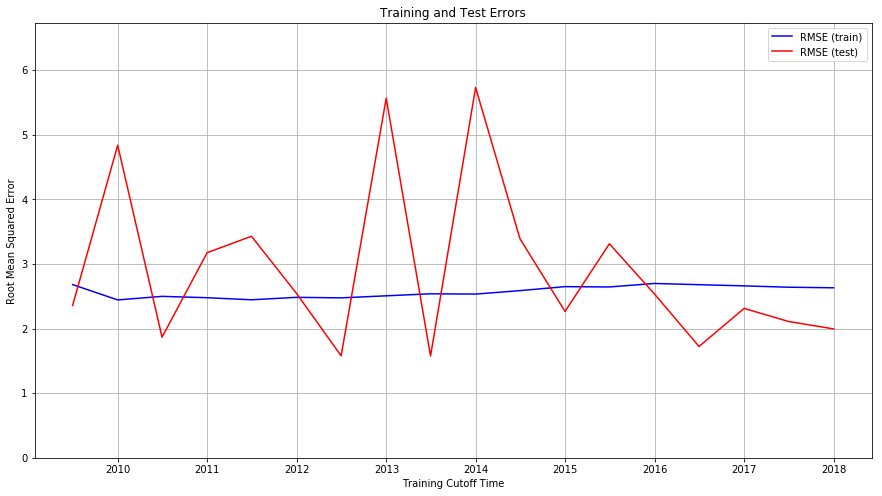

In [22]:
%%time

x = tmpf[tmpf.index > tmpf.index.min() + pd.DateOffset(365)].resample('6M').size().index.date[:-1]
y_train = []
y_test = []
for date in x:
    model, train, test, predict, forecast_df = ARMA_train_forecast(tmpf, date, diffs = [24 * 365, 1],
                                                                            order = (2, 2),
                                                                            freq = 'H')
    y_train.append(rmse(train.loc[predict.index], predict))
    y_test.append(rmse(test, forecast_df.forecast))
    
    print("Finished {}.".format(date))

fig, ax = plt.subplots(figsize = (15, 8))

ax.plot(x, y_train, color = 'blue', label = 'RMSE (train)');
ax.plot(x, y_test, color = 'red', label = 'RMSE (test)');
ax.legend()
ax.grid()
ax.set_title('Training and Test Errors')
ax.set_xlabel('Training Cutoff Time');
ax.set_ylabel('Root Mean Squared Error');
ax.set_ylim(0, max(y_train + y_test) + 1)